In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy as jsp
import optax
from minigp.utils import *

In [2]:
def loss_f_fit(params, model: ICNN_Grad, X, y):
    """
    Suppose we want the scalar f_\theta(x) to fit some target y (like regression).
    We'll do MSE: mean((f(x) - y)^2).
    """
    pred = model.f_batch(X, params)  # shape (batch,)
    return jnp.mean((pred - y)**2)

def loss_grad_fit(params, model: ICNN_Grad, X, y_grad):
    """
    Suppose we want the gradient f'(x) to fit some target vector y_grad (shape (batch, input_dim)).
    We'll do MSE on each component: mean(||grad_f(x) - y_grad||^2).
    """
    pred_grad = model.grad_batch(X, params)  # (batch, input_dim)
    return jnp.mean(jnp.sum((pred_grad - y_grad)**2, axis=1))

In [3]:
def quad_1d(x):
    y = x[0]**2 + 1
    return jnp.array([y])

In [4]:
def quad_1d_grad(x):
    y = x[0] * 2
    return jnp.array([y])

In [5]:
def generate_synthetic_data(
    func,
    grad,
    n_samples=100,
    input_dim=1,
    output_dim=1,
    x_range=(-2.0, 2.0),
    seed=0
):
    key = random.PRNGKey(seed)        # Initialize the RNG key
    X = random.uniform(
        key,
        shape=(n_samples, input_dim),
        minval=x_range[0],
        maxval=x_range[1]
    )
    Y = jnp.zeros((n_samples, output_dim), dtype=float)
    Ygrad = jnp.zeros((n_samples, output_dim), dtype=float)

    for i in range(n_samples):
        x_i = X[i]
        y_i = func(x_i)
        ygrad_i = grad(x_i)
        Y[i] = y_i
        Ygrad[i] = ygrad_i

    return X, Y, Ygrad

In [6]:
def sanity_check_1d_convex_and_gradient(func, grad):
    x_vals = jnp.linspace(-2, 2, 50)
    f_true_vals = x_vals**2 + 1.0
    grad_true_vals = 2.0 * x_vals

    X_train = jnp.array(x_vals.reshape(-1,1))  # shape (50,1)
    Yf_train = jnp.array(f_true_vals)          # shape (50,)
    Ygrad_train = jnp.array(grad_true_vals.reshape(-1,1)) # shape (50,1)

    X_train, Yf_train, Ygrad_train = generate_synthetic_data(func, grad)
    
    key = random.PRNGKey(42)
    layer_dims = [1, 16, 16, 16, 16, 1]
    model = ICNN_Grad(layer_dims, key)

    lr = 0.01
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(model.params)
    def update_f(params, opt_state):
        loss_val, grads = jax.value_and_grad(loss_f_fit)(params, model, X_train, Yf_train)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss_val

    for step in range(3000):
        model.params, opt_state, loss_val = update_f(model.params, opt_state)
        if step % 500 == 0:
            print(f"[f-fit] step={step}, loss={loss_val:.6f}")

    f_learned = model.f_batch(X_train, model.params)   # shape (50,)
    grad_learned = model.grad_batch(X_train, model.params)  # shape (50,1)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(x_vals, f_true_vals, 'k--', label='True f(x)=x^2+1')
    plt.plot(x_vals, jnp.array(f_learned), 'r-', label='Learned f')
    plt.title("Convex f(x) vs. Learned")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(x_vals, grad_true_vals, 'k--', label='True grad=2x')
    plt.plot(x_vals, jnp.array(grad_learned).squeeze(), 'r-', label='Learned grad')
    plt.title("Gradient vs. Learned grad")
    plt.legend()
    plt.show()

def sanity_check_1d_grad_fit(func, grad):
    x_vals = jnp.linspace(-2, 2, 50)
    grad_true_vals = 2.0 * x_vals  # derivative of x^2+1

    X_train = jnp.array(x_vals.reshape(-1,1)) 
    Ygrad_train = jnp.array(grad_true_vals.reshape(-1,1))

    X_train, Yf_train, Ygrad_train = generate_synthetic_data(func, grad)

    key = random.PRNGKey(0)
    layer_dims = [1, 16, 16, 16, 16, 1]
    model = ICNN_Grad(layer_dims, key)

    lr = 0.01
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(model.params)
    def update_grad(params, opt_state):
        loss_val, grads = jax.value_and_grad(loss_grad_fit)(params, model, X_train, Ygrad_train)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss_val

    for step in range(1000):
        model.params, opt_state, loss_val = update_grad(model.params, opt_state)
        if step % 500 == 0:
            print(f"[grad-fit] step={step}, loss={loss_val:.6f}")

    x_lin = jnp.array(x_vals.reshape(-1,1))
    f_learned = model.f_batch(x_lin, model.params)
    grad_learned = model.grad_batch(x_lin, model.params)

    f_true_vals = x_vals**2 + 1.0
    grad_true_vals = 2.0*x_vals

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(x_vals, f_true_vals, 'k--', label='True f(x)=x^2+1')
    plt.plot(x_vals, jnp.array(f_learned), 'r-', label='Learned f (mod offset)')
    plt.title("f(x) shape after gradient-fit")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(x_vals, grad_true_vals, 'k--', label='True grad=2x')
    plt.plot(x_vals, jnp.array(grad_learned).squeeze(), 'r-', label='Learned grad')
    plt.title("Gradient match")
    plt.legend()
    plt.show()


In [7]:
sanity_check_1d_convex_and_gradient(quad_1d, quad_1d_grad)

TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

[grad-fit] step=0, loss=31789.365234
[grad-fit] step=500, loss=19.839367


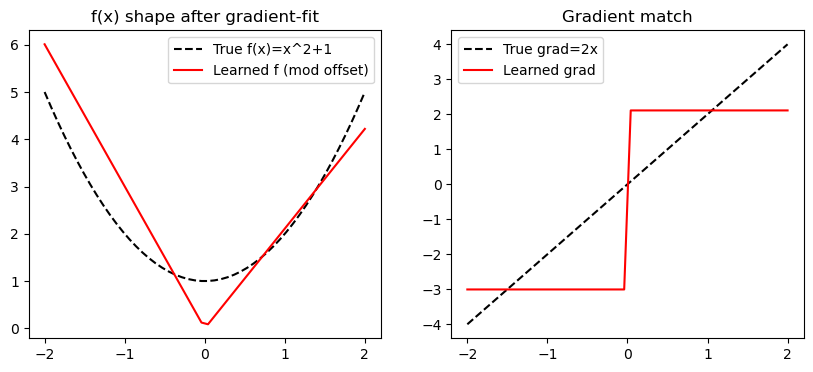

In [8]:
sanity_check_1d_grad_fit(quad_1d, quad_1d_grad)